In [1]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from dm_control import suite
import numpy as np
import matplotlib

In [2]:
# utility functions

# show videos in ipython given frames
# modified from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
def display_video(frames, framerate=30):
    dpi=70
    height, width = frames[0].shape[:2]
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi);

    matplotlib.use(orig_backend)  # switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])

    im = ax.imshow(frames[0], aspect='auto');
    def update(frame):
      im.set_data(frame)
      return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('position', array([-0.96264571,  0.47736283])), ('to_target', array([0.00846054, 0.13115565])), ('velocity', array([0., 0.]))]))

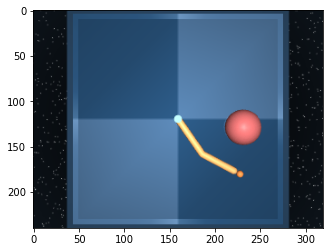

In [80]:
# load and explore reacher env
env = suite.load('reacher', 'easy')
observation_spec = env.observation_spec()
action_spec = env.action_spec()
time_step = env.reset()
img = env.physics.render(camera_id=0)
plt.imshow(img)
time_step

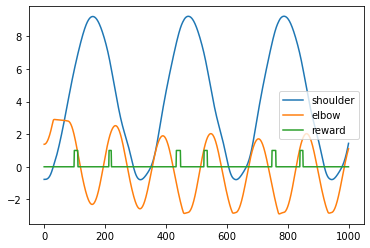

In [120]:
# show random action rollout
imgs = []
data = []  # (s0, s1, r)
time_step = env.reset()
while not time_step.last():
    t = env.physics.time()
    action = (np.sin(t), np.sin(t*2))  # shoulder, elbow
    time_step = env.step(action)
    imgs.append(env.physics.render(camera_id=0))
    data.append(np.append(time_step.observation['position'], time_step.reward))
plt.plot(np.array(data));
plt.legend(('shoulder', 'elbow', 'reward'));

In [112]:
display_video(imgs)

[0.         1.57079633]


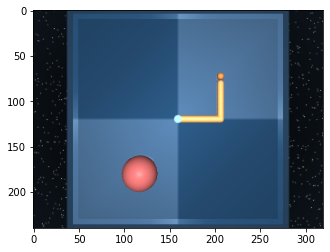

In [163]:
# set state
state = (0,np.pi/2,2,2)  # position, velocity

def set_state(state):
    with env.physics.reset_context():
        env.physics.data.qpos[:] = state[:2]
        env.physics.data.qvel[:] = state[2:]
        print(env.physics.data.qpos)

set_state(state)
plt.imshow(env.physics.render(camera_id=0))




In [228]:
class Arm:
    
    def __init__(self):
        # todo: figure out whether it makes sense to have main and simulation env...
        self.env = suite.load('reacher', 'easy')
        self.env.reset()  # initial randomization appears to require this line... :/
        self.max_steps = self.env._step_limit
        self.Q = np.diag((0,0,1,1,0,0))  # only weight distance from target
        self.R = np.zeros((6,6))         # no control costs for now
    
    def step(self, action):
        state = self.parse_timestep(self.env.step(action))
        return state
    
    def rollout(self, actions):
        states = []
        env.reset()
        for i in range(self.max_steps):
            states.append(self.step(action))
        return states
    
    def cost(self, state, action):
        # J(t) = .5*(x^TQx + uTRt)
        J =  .5 * np.dot(self.state,  np.matmul(self.Q, self.s self tate))
        J += .5 * np.dot(self.action, np.matmul(self.R, self.action))
    
    def cost_final(self, state):
        J =  .5 * np.dot(self.state,  np.matmul(self.Q, self.state))
    
    def cost_derivs(self, state, action):
        """ l_x l_u l_xu l_xx l_uu """
        pass
    
    def state_derivs(self, state, action):
        """ f_x f_u"""
        sim_state = lambda x: self.simulate(x, action)  # keeping action constant
        fx = self.finite_differences(sim_state, state)
        
        sim_action = lambda x: self.simulate(state, x)  # keeping state constant
        fu = self.finite_differences(sim_action, action)
        
        return fx, fu
    
    def simulate(self, state, action):
        """ get subsequent state from (state, action) """
        self.set_state(state)
        state_next = self.step(action)
        return state_next
    
    def set_state(self, state):
        """ set state without changing target position """
        with self.env.physics.reset_context():
            self.env.physics.data.qpos[:] = state[:2]
            self.env.physics.data.qvel[:] = state[-2:]
    
    @staticmethod
    def parse_timestep(time_step):
        """ extract state (p0, p1, to_target0, to_target1, v0, v1) """
        return np.concatenate(list(time_step.observation.values()))
    
    @staticmethod
    def finite_differences(fcn, x, eps=1e-4):
        # todo: vectorize (assuming fcn is vectorized)
        x = np.array(x)
        diffs = []
        for i in range(len(x)):
            x_inc = x.copy()
            x_dec = x.copy()
            x_inc[i] += eps
            x_dec[i] -= eps
            diffs.append((fcn(x_inc) - fcn(x_dec)) / (eps*2))
        return np.array(diffs)
    
    def render(self):
        return self.env.physics.render(camera_id=0)
        

(2, 6)

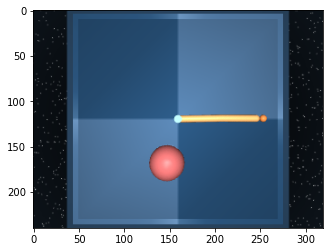

In [242]:
arm = Arm()
arm.set_state((0,0,0,0,0,0))
fx, fu = arm.state_derivs((0,0,0,0,0,0), (1,1))  # negative is clockwise
plt.imshow(arm.render());
np.array(fu).shape

In [244]:
class PointMass:
    
    def __init__(self):
        self.mass = 1
        self.position = np.array([0, 0])
        self.velocity = np.array([0, 0])

        
        # render
        fig =  plt.figure(figsize=(10,10))
        self.ax = plt.axes()
        self. self  
        
    def reset():
        pass
    
    
    def render():
        pass

In [ ]:
def iLQR(env, iterations=100):
    
    """
    simulate initial trajectory
    for iterations:
        compute l_x, l_u, l_ux, l_uu, l_xx, f_x, f_u (for each t) in FORWARD loop
        compute final cost
        in backward pass compute k, K, V
    """
    
    
    





















































